In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#to read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
block_size = 3 # this represents how many letters of context the model considers before choosing the next letter
X, Y = [], []

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27, 2)) #embedding with 2 features

In [8]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn((6, 100)) # 3 input with 2d embeddings for each means 6 total inputs
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [11]:
#need to transform the 32, 3, 2 into 32, 6
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [12]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [13]:
a = torch.arange(18)
a.view(3, 3, 2) #View is extremely efficient apparently because it accesses the 1d version of the tensor 
# no new storage, just internals are being changed

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [14]:
W2 = torch.randn((100, 27)) # 27 possible outputs
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [23]:
loss = -(prob[torch.arange(228146), Y]).log().mean()
loss

tensor(16.6204)

# Rewritten below

In [24]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [45]:
def build_dataset(words):
    block_size = 3 # this represents how many letters of context the model considers before choosing the next letter
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [74]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) #embeddings
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [75]:
sum(p.nelement() for p in parameters)

11897

In [76]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
plt.plot(lri, lossi)

In [85]:
# lri = []
# lossi = []
# stepi = []
for i in range(100000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass 
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) #we can avoid creating intermediate tensors
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = lrs[i]
    lr = 0.005
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats for lr
    # lri.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.item())
# print(loss.item()) 

In [59]:
print(loss.item())

2.491687536239624


In [86]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1720, grad_fn=<NllLossBackward0>)

In [87]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2004, grad_fn=<NllLossBackward0>)

Since loss is similar for dev and tr set, we are not overfitting. In fact we are underfitting which means that we can expect improvements by expanding the model

The reason we are not getting 0 or close to zero is because
predicting the first letter is not straight forward in general. You can't 
really find a pattern with that

# How to determine a reasonable learning rate?
If the loss is barely decreasing after 100 tries then its too small \
If the loss is not changing or varying too much then its way too large \
We can use torch.linspace for a range ex. between 0.001 and 1 
for candidate learning rates

Training split, validation split, test split for more accurate losses \
80%, 10%, 10%

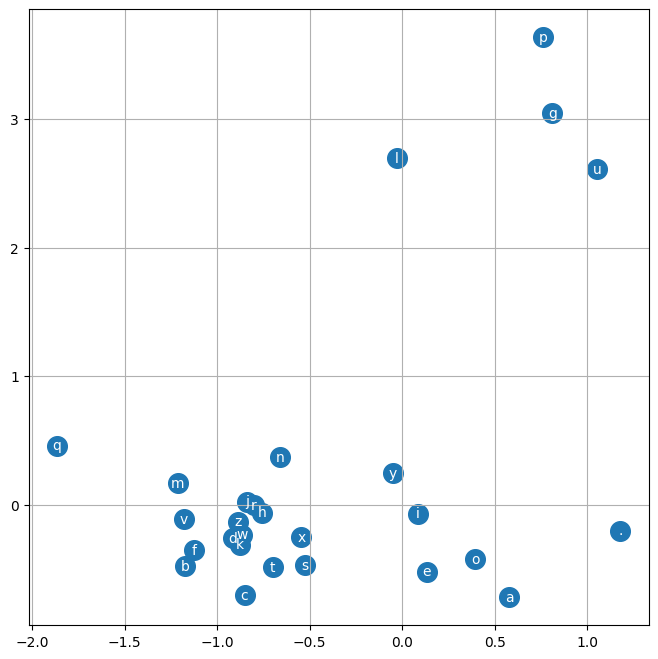

In [73]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Hyperparameters of this model:
- context
- embedding dimensionality
- how long the loop runs
- learning rate
- neurons per layer
- layers

In [89]:
g = torch.Generator().manual_seed (2147483647 + 11)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

reenai.
rain.
cruzra.
nearyan.
nikeriez.
zaisrain.
ell.
fari.
evion.
malaxibray.
isnevur.
ezie.
jiquine.
jed.
les.
lol.
kame.
srija.
marshe.
mola.
